In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import sklearn
from io import StringIO
from Bio import Phylo
import re

from ete3 import Tree
from matplotlib.colors import ListedColormap

import phylovelo as pv


/home/wangkun/LineageTracingwithscRNA/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
count = pd.read_csv('/raid/wangkun/embryo2/scRNA_raw_counts.csv', index_col=0)

In [4]:
count = count.T

In [5]:
metadata = pd.read_csv('/raid/wangkun/embryo2/scRNA_metadata.csv', index_col=0)

In [6]:
from ete3 import Tree
from io import StringIO

with open('/home/wangkun/datas/embryo/trees/embryo2_all.newick', 'r') as f:
    tree_nwk = f.readline()
t = Tree(tree_nwk)
f = StringIO(t.write())
tree = Phylo.read(f, 'newick')
f.close()

In [7]:
terminals = [i.name for i in tree.get_terminals()]
cell_names = list(set(count.index).intersection(set(terminals)))
# cell_names = set(metadata[np.isin(metadata.cluster, list(cell_type_map.keys()))].index)

In [8]:
count = count.loc[cell_names]

In [9]:
import anndata as ad
adata = ad.AnnData(count)
sd = pv.data_struct.scData(count=pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names))

In [10]:
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sd.x_normed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [11]:
# pd.DataFrame(sd.x_normed.columns).to_csv('embryo2_genes.csv')

In [12]:
# adata.obs['clusters'] = [cell_type_map[i] for i in metadata.loc[sd.count.index]['cluster']]
adata.obs['clusters'] = metadata.loc[sd.count.index]['cluster']

In [13]:
# tsne = pd.read_csv('/raid/wangkun/embryo2/neural_tsne.csv', index_col=0)
# adata.obsm['X_tsne'] = tsne.loc[sd.count.index]

In [14]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)

In [15]:
sc.tl.tsne(adata,random_state=1, perplexity=10)

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


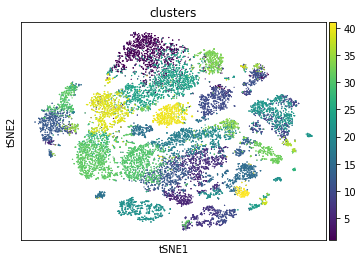

In [16]:
sc.pl.tsne(adata, color=["clusters"])

In [17]:
sd.Xdr = pd.DataFrame(data=adata.obsm['X_tsne'], index=adata.obs_names)

In [18]:
# count = count[~count.index.duplicated(keep='first')]
# sd = pv.data_struct.scData(count=count)
# sd.x_normed = count
# sd.normalize_filter(False, False, 0)

In [19]:
sd.phylo_tree = tree

In [20]:
sd.drop_duplicate_genes(target='x_normed')

In [14]:
tree_depths = tree.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths = [depths_map[i] for i in sd.count.index]

# depths = [int(mut_num.loc[i]) for i in sd.count.index]

In [22]:
# np.random.shuffle(depths)

In [70]:
sd.cell_states = np.array([metadata.loc[i].cluster for i in sd.count.index])

In [23]:
sd = pv.inference.velocity_inference(sd, depths, cutoff=0.97, target='x_normed')

  0%|          | 0/15605 [00:00<?, ?it/s]

/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/wangkun/LineageTracingwithscRNA/phylovelo/inference.py:135: RuntimeWarning: invalid value encountered in double_scalars
  lr = 2 * (lh1 - lh0)


In [25]:
from scipy.stats import spearmanr
v_megs = pd.DataFrame(data=[sd.x_normed.columns, sd.velocity]).T
v_megs.columns = ['MEGs', 'v']
v_megs['p-value'] = v_megs['MEGs'].apply(lambda x: spearmanr(sd.x_normed[x], depths)[1])

In [27]:
vels_em2 = v_megs[v_megs['v']!=0]

In [26]:
v_megs[v_megs['v']!=0].to_csv('embryo2_all_shuffle_meg.csv', index=False)
# v_megs[v_megs['v']!=0].to_csv('embryo2_neural.csv', index=False)

In [ ]:
vels_em2 = pd.read_csv('./buckup/embryo2_all.csv', index_col=0)
vels_em3 = pd.read_csv('./buckup/embryo3_all.csv', index_col=0)

In [26]:
vels2 = []
common_genes = list(set(vels_em2.index).intersection(vels_em3.index))
for i in common_genes:
    try:
        vels2.append(vels_em2['v'][i])
    except:
        vels2.append(0)

vels3 = []
for i in common_genes:
    try:
        vels3.append(vels_em3['v'][i])
    except:
        vels3.append(0)

In [30]:
import numpy as np

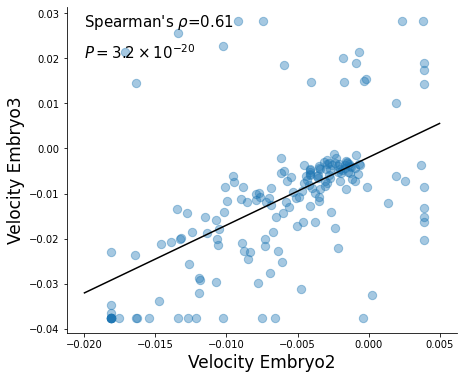

In [39]:
x = vels2
y = vels3

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(-0.02,0.005,60) + b

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(-0.02,0.005,60), y_est, '-', c='k')
ax.set_xlabel('Velocity Embryo2', fontsize=17)
ax.set_ylabel('Velocity Embryo3', fontsize=17)
rho, pval = spearmanr(x, y)
ax.text(-0.02, 0.027, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(-0.02, 0.02, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Text(0.04, 0.5, 'Total normalized UMI of MEGs')

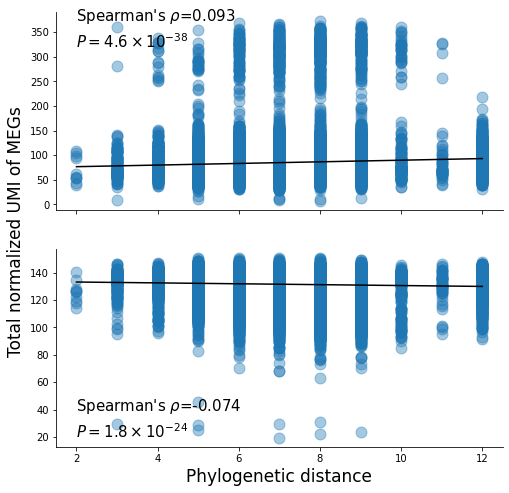

In [50]:

x = depths
y = sd.x_normed[genes1].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax[0].scatter(x, y, alpha=0.4, s=120)
ax[0].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[0].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
# ax[0].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[0].text(min(x)*1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[0].text(min(x)*1, max(y)-(max(y)-min(y))*0.15, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

# ax.text(min(x)*1.1, min(y)*1.05, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
# ax.text(min(x)*1.1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


x = depths
y = sd.x_normed[genes2].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b


ax[1].scatter(x, y, alpha=0.4, s=120)
ax[1].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[1].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
ax[1].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[1].text(min(x)*1, min(y)+(max(y)-min(y))*0.15, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[1].text(min(x)*1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

fig.text(0.04, 0.5, 'Total normalized UMI of MEGs', va='center', rotation='vertical',fontsize=17)